In [5]:
!pip install -q memory_profiler

DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: professor2 X.Y.Z has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of professor2 or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
%reload_ext memory_profiler

In [1]:
%load_ext autoreload

In [1]:
model_file = "models_archive/model_onlytransformer.py"
config_json = "training_config/training_run3_transformer/training_run3_transformer_v2.json"

In [2]:
import awk_data
import awkward as ak
import tensorflow as tf
import loader
import argparse 
from collections import defaultdict
import os, json
import importlib.util
from time import time
import numpy as np
from plotting import * 
import plot_loss
from time import sleep

config = json.load(open(config_json))

config['activation'] = tf.keras.activations.get(config['activation'])

# Checking hardware
print('version={}, CUDA={}, GPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    len(tf.config.list_physical_devices('GPU')) > 0))
      
gpus =  tf.config.list_physical_devices('GPU')

# if len(gpus) ==1 :
#     print("Using 1 GPU")
#     tf.config.experimental.set_memory_growth(gpus[0], enable=True)
#     strategy = tf.distribute.OneDeviceStrategy("gpu:0")
# elif len(gpus):
#     print("Using {} GPUs".format(len(gpus)))
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, enable=True)
#     strategy = tf.distribute.MirroredStrategy()
# else:
#     strategy = tf.distribute.OneDeviceStrategy("cpu:0")
if len(gpus) >=1 :
    print("Using 1 GPU")
    #tf.config.experimental.set_memory_growth(gpus[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")
else:
    strategy = tf.distribute.OneDeviceStrategy("cpu:0")


##################
# Prepare the output folder
def get_unique_run():
    previous_runs = os.listdir(config["models_path"])
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('_')[1]) for s in previous_runs if s.startswith("run")]) + 1
    return run_number

if not os.path.isdir(config["models_path"]):
    os.makedirs(config["models_path"])

name =  'run_{:02}'.format(get_unique_run())

outdir = config["models_path"] + "/"+ name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print("Model output folder: ", outdir)

############################3
#Copying the config file and model file in the output dir:
os.system("cp {} {}".format(config_json, outdir))
os.system("cp {} {}".format(model_file, outdir))

###########################
## Loading the datasets
print(">>> Loading datasets")

2024-05-14 11:09:32.783419: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 11:09:35.718796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


version=2.13.1, CUDA=True, GPU=True
Using 1 GPU


2024-05-14 11:09:59.616744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 11:10:01.495337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 11:10:01.500541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model output folder:  /eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/Run3_126X_2023/tests_transformer//run_92
>>> Loading datasets


In [3]:
train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["training"]))
test_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["validation"]))
# Create training and validation
#ds_train = train_ds.prefetch(tf.data.AUTOTUNE)
#ds_train = train_ds

In [4]:
dataset = awk_data.load_tfdataset_and_original(awk_data.LoaderConfig(**config["dataset_conf"]["training"]))

In [5]:
it = iter(dataset)

In [6]:
X, original = next(it)

In [7]:
X

((<tf.Tensor: shape=(1024, 16, 19), dtype=float64, numpy=
  array([[[ 1.45726357,  3.02626728,  0.94334068, ...,  0.38866984,
           -0.57844223,  3.08029633],
          [-0.39514866, -0.49994396,  0.94962241, ...,  0.83553335,
           -2.91788379,  0.92463048],
          [-0.40326656, -0.51580964,  1.00894819, ..., -0.70174914,
            0.66232317, -0.6322393 ],
          ...,
          [-0.        , -0.        , -0.        , ..., -0.        ,
           -0.        , -0.        ],
          [-0.        , -0.        , -0.        , ..., -0.        ,
           -0.        , -0.        ],
          [-0.        , -0.        , -0.        , ..., -0.        ,
           -0.        , -0.        ]],
  
         [[ 2.37268703,  2.53997749, -1.37052835, ...,  0.72198008,
            0.21140441,  1.88270419],
          [-0.38038649, -0.49328143, -1.37495259, ...,  2.39560492,
           -0.80021165,  0.32583441],
          [-0.39744959, -0.51293116, -1.44344949, ..., -0.86395965,
       

In [11]:
original.cl_features.en_cluster[0].tolist()

[980.0921630859376,
 6.295756816864014,
 2.028249740600586,
 0.8994665145874023,
 0.6117829084396362]

In [12]:
X[1][2][0,:,0]

<tf.Tensor: shape=(17,), dtype=float64, numpy=
array([9.80092163e+02, 6.29575682e+00, 2.02824974e+00, 8.99466515e-01,
       6.11782908e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])>

### Profiling

In [4]:
print(config["dataset_conf"]["training"])

{'input_folders': ['/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/run3_126X_2023/awkward_126X_mcRun3_2023_forPU65_v4/training', '/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/run3_126X_2023/awkward_126X_mcRun3_2023_forPU65_v4/training'], 'file_input_columns': ['cl_features', 'cl_labels', 'window_features', 'window_metadata', 'cl_h'], 'columns': {'cl_features': ['en_cluster', 'et_cluster', 'cluster_eta', 'cluster_phi', 'en_cluster_log', 'et_cluster_log', 'cluster_ieta', 'cluster_iphi', 'cluster_iz', 'cluster_deta', 'cluster_dphi', 'cluster_den_seed', 'cluster_det_seed', 'cluster_den_seed_log', 'cluster_det_seed_log', 'cl_etaWidth', 'cl_phiWidth', 'cl_swissCross', 'cl_nxtals'], 'cl_labels': ['in_scluster', 'is_seed'], 'window_metadata': ['flavour', 'nVtx', 'rho', 'obsPU', 'truePU', 'ncls', 'nclusters_insc', 'en_true_gen', 'en_true_sim'], 'window_features': ['max_en_cluster', 'max_et_cluster', 'max_deta_cluster', 'max_dphi

In [5]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["batch_size"] = 512
cfg["nworkers"] = 1
cfg["max_batches_in_memory"] = 50

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)
           

156 ms ± 81.6 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [22]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 2000000
cfg["chunk_size"] = 4096 # 5120
cfg["batch_size"] = 1024
cfg["nworkers"] = 1
cfg["max_batches_in_memory"] = 24

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)

In [15]:
result = %timeit -n 100 -r 10 -o next(it)

190 ms ± 49.3 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [21]:
%%memit
start = time()
Nbatches = 100
for i, a  in enumerate(train_ds):
    if i > Nbatches: break
    sleep(0.1)
    pass
end = time()

print(f"evt/s: {cfg['batch_size']*Nbatches/(end-start):.3f}")
print(f"batches/s: {Nbatches/(end-start):.3f}")
print(f"s/batches: {(end-start)/Nbatches:.3f}")

Multiprocessing generator closed
evt/s: 3491.216
batches/s: 3.409
s/batches: 0.293
peak memory: 2675.28 MiB, increment: 379.53 MiB


In [33]:
np.linspace(0,1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [6]:
results = []
for t in np.linspace(0,1, 11):
    print(f"time {t}")
    train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
    it = iter(train_ds)
    Nbatches = 100
    start = time()
    for i, a  in enumerate(train_ds):
        if i > Nbatches: break
        sleep(t)
    end = time()
    results.append((end-start)/Nbatches)
    print(results)

time 0.0
[0.19164735078811646]
time 0.1
[0.19164735078811646, 0.17593022108078002]
time 0.2
[0.19164735078811646, 0.17593022108078002, 0.25264973640441896]
time 0.30000000000000004
[0.19164735078811646, 0.17593022108078002, 0.25264973640441896, 0.3487835478782654]
time 0.4
[0.19164735078811646, 0.17593022108078002, 0.25264973640441896, 0.3487835478782654, 0.44688528776168823]
time 0.5
[0.19164735078811646, 0.17593022108078002, 0.25264973640441896, 0.3487835478782654, 0.44688528776168823, 0.5471558403968811]
time 0.6000000000000001
[0.19164735078811646, 0.17593022108078002, 0.25264973640441896, 0.3487835478782654, 0.44688528776168823, 0.5471558403968811, 0.6528098344802856]
time 0.7000000000000001
[0.19164735078811646, 0.17593022108078002, 0.25264973640441896, 0.3487835478782654, 0.44688528776168823, 0.5471558403968811, 0.6528098344802856, 0.7493509531021119]
time 0.8
[0.19164735078811646, 0.17593022108078002, 0.25264973640441896, 0.3487835478782654, 0.44688528776168823, 0.5471558403968

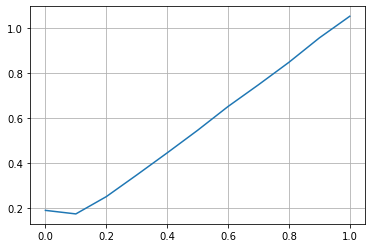

In [11]:
plt.plot(np.linspace(0,1, 11),  np.array(results))
plt.grid()

In [26]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["batch_size"] = 512
cfg["nworkers"] = 1
cfg["max_batches_in_memory"] = 50

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

193 ms ± 18.1 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [24]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["batch_size"] = 512
cfg["nworkers"] = 2
cfg["max_batches_in_memory"] = 50

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

112 ms ± 17.3 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [25]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["batch_size"] = 1024
cfg["nworkers"] = 3
cfg["max_batches_in_memory"] = 50

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

StopIteration: 

In [14]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["batch_size"] = 512
cfg["nworkers"] = 3
cfg["max_batches_in_memory"] = 50

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)
                                

86.4 ms ± 37.4 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [15]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["chunk_size"] = 512*20
cfg["batch_size"] = 512
cfg["nworkers"] = 3
cfg["max_batches_in_memory"] = 50

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)
                      

81.5 ms ± 22.3 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [16]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["chunk_size"] = 512*20
cfg["batch_size"] = 512
cfg["nworkers"] = 3
cfg["max_batches_in_memory"] = 300

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

87.7 ms ± 33.6 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [17]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["chunk_size"] = 512*20
cfg["batch_size"] = 512
cfg["nworkers"] = 3
cfg["max_batches_in_memory"] = 300

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

95.8 ms ± 35 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [18]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["chunk_size"] = 512*10
cfg["batch_size"] = 512
cfg["nworkers"] = 3
cfg["max_batches_in_memory"] = 300

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

91.9 ms ± 33.9 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [19]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["chunk_size"] = 512*10
cfg["batch_size"] = 512
cfg["nworkers"] = 6
cfg["max_batches_in_memory"] = 300

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

93.2 ms ± 26.8 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [20]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["batch_size"] = 512
cfg["nworkers"] = 2
cfg["max_batches_in_memory"] = 50

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)
                                

118 ms ± 31.4 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [21]:
cfg = config["dataset_conf"]["training"]
cfg["maxevents"] = 512000
cfg["batch_size"] = 512
cfg["nworkers"] = 2
cfg["max_batches_in_memory"] = 100

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**cfg))
it = iter(train_ds)
                                
result = %timeit -n 100 -r 10 -o next(it)

110 ms ± 18.4 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [22]:
result

<TimeitResult : 110 ms ± 18.4 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [6]:
126 / (1000000 / 521)

0.065646

In [4]:
%%time

for x,y, w in ds_train:
    pass

2022-09-25 12:28:04.797692: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: AttributeError: 'LoaderConfig' object has no attribute 'reweight_file'
Traceback (most recent call last):

  File "/work/dvalsecc/miniconda3/envs/clustering_tf2.3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/work/dvalsecc/miniconda3/envs/clustering_tf2.3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/work/dvalsecc/miniconda3/envs/clustering_tf2.3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/work/dvalsecc/Clustering/DeepSuperCluster/Training/global_model/awk_data.py", line 564, in _gen
    file_loader_generator = load_batches_from_files_generator(config, preprocessing)

  File "/work/dvalsecc/Clustering/DeepSuperClust

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_12_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: 'LoaderConfig' object has no attribute 'reweight_file'
Traceback (most recent call last):

  File "/work/dvalsecc/miniconda3/envs/clustering_tf2.3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/work/dvalsecc/miniconda3/envs/clustering_tf2.3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/work/dvalsecc/miniconda3/envs/clustering_tf2.3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/work/dvalsecc/Clustering/DeepSuperCluster/Training/global_model/awk_data.py", line 564, in _gen
    file_loader_generator = load_batches_from_files_generator(config, preprocessing)

  File "/work/dvalsecc/Clustering/DeepSuperCluster/Training/global_model/awk_data.py", line 346, in load_batches_from_files_generator
    _preprocess_fn = preprocessing_fn(config)

  File "/work/dvalsecc/Clustering/DeepSuperCluster/Training/global_model/awk_data.py", line 387, in preprocessing
    cset = correctionlib.CorrectionSet.from_file(config.reweight_file)

AttributeError: 'LoaderConfig' object has no attribute 'reweight_file'


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

# Checks on Nans and inf

In [11]:
for i,(X,Y,w) in enumerate(ds_train()):
    mask = X[4] -1
    mask[mask==-1] = 1
    mask_rec = X[5]-1
    mask_rec[mask_rec==-1] = 1
    s = np.sum(X[0] * mask[:,:,None]) + np.sum(Y[2] * mask[:,:,None]) + np.sum(X[2]*mask_rec[:,:,:,None])
    if s != 0:
        break
    else:
        print(".", end="")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
for j, (x,y ,w) in enumerate(ds_train):
    print(j, end="> ")
    found = False
    for i in [0,1,2,4,5]:
        a = tf.reduce_sum(tf.cast(tf.math.is_nan(x[i]), tf.int64)) + tf.reduce_sum(tf.cast(tf.math.is_inf(x[i]), tf.int64)) 
        print(a, end=", ")
        if a.numpy() != 0:
            found = True
    print()
    if found : break
    

0> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
1> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
2> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
3> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
4> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
5> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, sh

In [5]:
############### 
# Loading the model file
 # Load model modules
spec = importlib.util.spec_from_file_location("model", model_file)
model_lib = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model_lib)

tf.keras.backend.clear_session()
# Construction of the model in the strategy scope
with strategy.scope():
    print(">>> Creating the model")
    # Build the model with all the configs
    model = model_lib.DeepClusterGN(**config)

    #optimizer
    if config['opt'] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=config['lr'])

    #compile the model
    model.compile(optimizer=opt)
    model.set_metrics()

    for X, y ,w  in ds_train:
        # Load the model
        ypred = model(X, training=False)
        #l = custom_loss(y, ypred)
        break

    model.summary()
    

>>> Creating the model
Model: "deep_cluster_gn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_builder (GraphBuildin  multiple                 78267     
 g)                                                              
                                                                 
 GHN_global (GHConvI)        multiple                  8256      
                                                                 
 SA_clclass (SelfAttentionBl  multiple                 24960     
 ock)                                                            
                                                                 
 dense_clclass (Sequential)  (256, 24, 1)              90753     
                                                                 
 SA_windclass (SelfAttention  multiple                 41344     
 Block)                                                          
                            

In [ ]:
history = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=config['nepochs'],
        steps_per_epoch=120, 
        validation_steps=2,
        verbose=2,
    )

In [7]:
for j, (x,y ,w) in enumerate(ds_train):
    print(j, end="> ")
    found = False
    for i in [0,1,2,4,5]:
        a = tf.reduce_sum(tf.cast(tf.math.is_nan(x[i]), tf.int64)) + tf.reduce_sum(tf.cast(tf.math.is_inf(x[i]), tf.int64))
        print(a, end=", ")
        if a.numpy() != 0:
            found = True
    ypred = model(x)
    for i in [0,1,2]:
        a = tf.reduce_sum(tf.cast(tf.math.is_nan(ypred[0][i]), tf.int64)) + tf.reduce_sum(tf.cast(tf.math.is_inf(ypred[0][i]), tf.int64))
        print(a, end=", ")
        if a.numpy() != 0:
            found = True
    print()
    if found : break
    

0> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
1> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
2> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), 
3> tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), dtype=int64), tf.Tensor(0, shape=(), 

KeyboardInterrupt: 

In [ ]:
train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["training"]))
test_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["validation"]))
# Create training and validation
ds_train = train_ds.prefetch(tf.data.AUTOTUNE)